# Assessing Quality of Nighttime Lights Data

### Overview <a name="overview"></a>

The quality of nighttime lights data can be impacted by a number of factors, particularly cloud cover. To facilitate analysis using high quality data, Black Marble (1) marks the quality of each pixel and (2) in some cases of poor quality pixels, Black Marble will use data from a previous date to fill the value---using a temporally-gap filled NTL value. Below we illustrate how to examine the quality of nighttime lights data.

### Setup <a name="setup"></a>

We first load packages and obtain a polygon for a region of interest; for this example, we use Switzerland. 

In [1]:
!python -m pip uninstall blackmarblepy --yes

Found existing installation: blackmarblepy 0.2.2
Uninstalling blackmarblepy-0.2.2:
  Successfully uninstalled blackmarblepy-0.2.2


In [2]:
!pip install git+https://github.com/worldbank/blackmarblepy@fill-value

  Cloning https://github.com/worldbank/blackmarblepy (to revision fill-value) to /private/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/pip-req-build-9pngijzw
  Running command git clone --filter=blob:none --quiet https://github.com/worldbank/blackmarblepy /private/var/folders/m1/8h14xfm56hd6qfgz6btm1rd80000gn/T/pip-req-build-9pngijzw
  Running command git checkout -b fill-value --track origin/fill-value
  Switched to a new branch 'fill-value'
  Branch 'fill-value' set up to track remote branch 'fill-value' from 'origin'.
  Resolved https://github.com/worldbank/blackmarblepy to commit a041c815ca9766fa27e407f1b2d0fb4c752d8871
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for blackmarblepy: filename=blackmarblepy-0.2.2-py3-none-any.whl size=24238 sha256=b0670ecfdebf8930aaaab92d21736f883e1cfbfa96f3f5f6ae9cb8cdb3c0e8fd
  Stored in directory: 

In [3]:
import datetime
import glob
import os
import time

import colorcet as cc
import contextily as cx
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
from gadm import GADMDownloader
from rasterstats import zonal_stats

from blackmarble.extract import bm_extract
from blackmarble.raster import bm_raster, transform

plt.rcParams["figure.figsize"] = (15, 5)
%load_ext autoreload
%autoreload 2

In [4]:
bearer = os.getenv("BLACKMARBLE_TOKEN")

In [5]:
bearer = pd.read_csv("/Users/robmarty/Desktop/bearer_bm.csv")["token"][0]

In [6]:
gdf = GADMDownloader(version="4.0").get_shape_data_by_country_name(
    country_name="Switzerland", ad_level=0
)

### Daily Data <a name="daily"></a>

Below shows an example examining quality for daily data (`VNP46A2`).

#### Gap Filled Nighttime Lights <a name="daily-ntl"></a>

We download data for January 1st, 2023. When the `variable` parameter is not specified, `bm_raster` creates a raster using the `Gap_Filled_DNB_BRDF-Corrected_NTL` variable for daily data.  This variable "gap fills" poor quality observations (ie, pixels with cloud cover) using data from previous days. 

In [7]:
ntl_r = bm_raster(
    gdf,
    product_id="VNP46A2",
    date_range="2023-01-01",
    bearer=bearer,
    variable="Gap_Filled_DNB_BRDF-Corrected_NTL",
)

GETTING MANIFEST...:   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

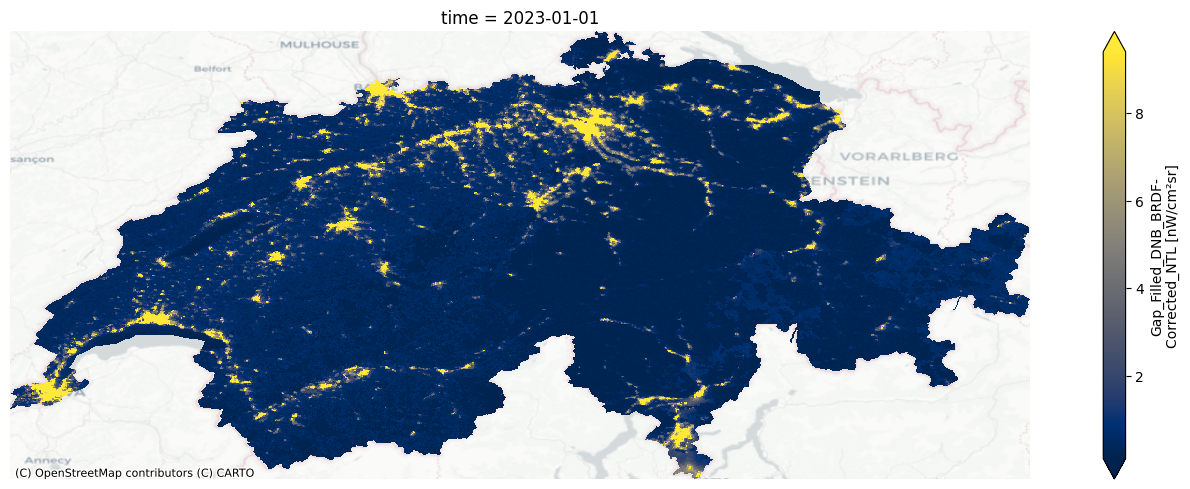

In [8]:
fig, ax = plt.subplots()

ntl_r["Gap_Filled_DNB_BRDF-Corrected_NTL"].sel(time="2023-01-01").plot(
    robust=True, cmap="cividis"
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout()

The `Latest_High_Quality_Retrieval` indicates the number of days since the current date that the nighttime lights value comes from for gap filling.

In [9]:
ntl_tmp_gap_r = bm_raster(
    gdf,
    product_id="VNP46A2",
    date_range="2023-01-01",
    bearer=bearer,
    variable="Latest_High_Quality_Retrieval",
)

GETTING MANIFEST...:   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

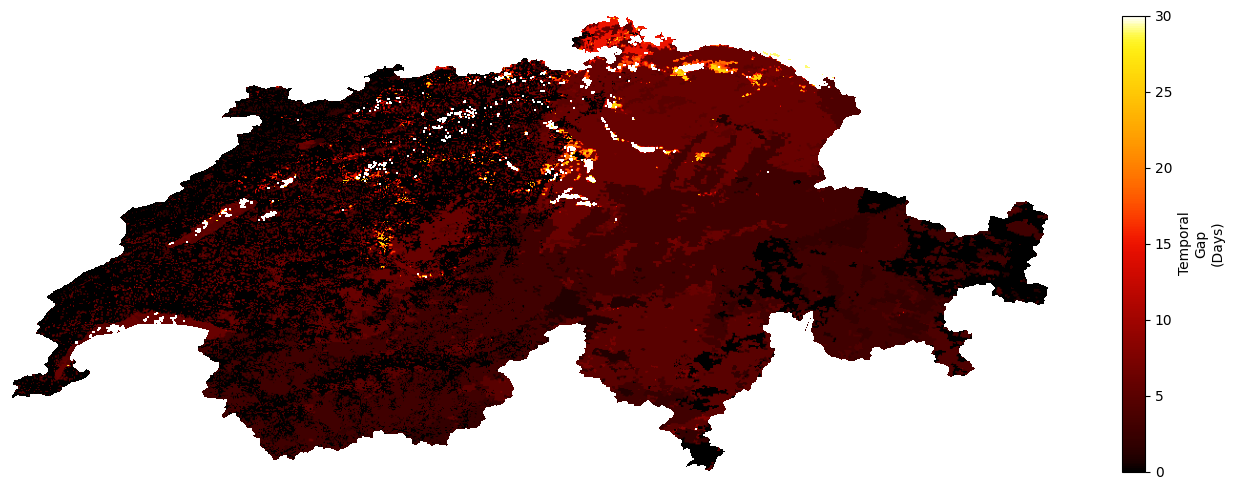

In [10]:
r_np = ntl_tmp_gap_r["Latest_High_Quality_Retrieval"].sel(time="2023-01-01")
r_np = np.where(r_np == 255, np.nan, r_np)

plt.imshow(r_np, cmap=cc.cm.fire)
plt.axis("off")
plt.colorbar(
    label="Temporal\nGap\n(Days)"
)  # Add a colorbar with ticks for discrete values
plt.tight_layout()

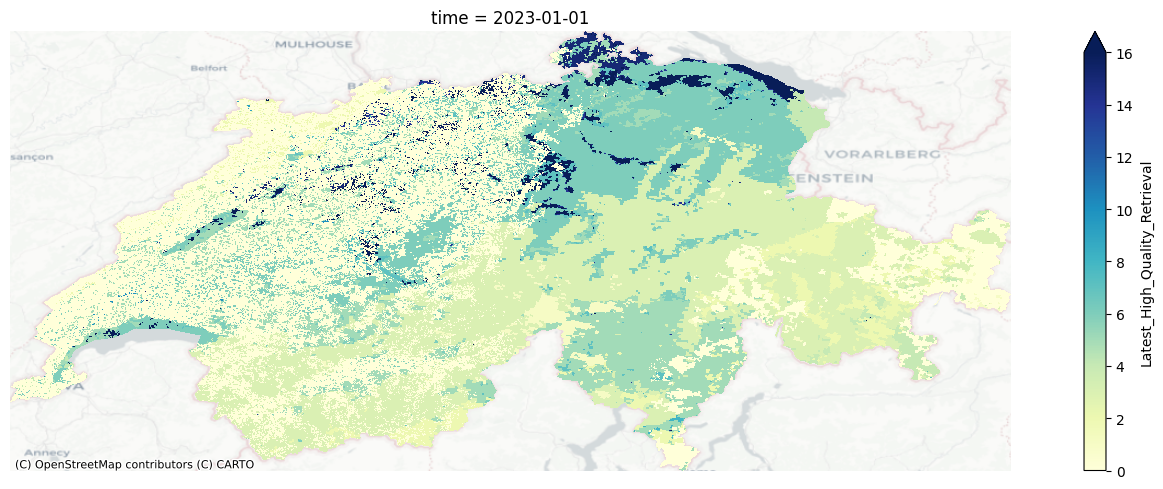

In [13]:
fig, ax = plt.subplots()

ntl_tmp_gap_r["Latest_High_Quality_Retrieval"].sel(time="2023-01-01").plot(
    robust=True, cmap="YlGnBu"
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout()

#### Non gap filled nighttime lights <a name="daily-ntl-nongap"></a>

Instead of using gap-filled data, we could also just use nighttime light values from the date selected using the `DNB_BRDF-Corrected_NTL` variable.

In [9]:
ntl_r = bm_raster(
    gdf,
    product_id="VNP46A2",
    date_range="2023-01-01",
    bearer=bearer,
    variable="DNB_BRDF-Corrected_NTL"
)

GETTING MANIFEST...:   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

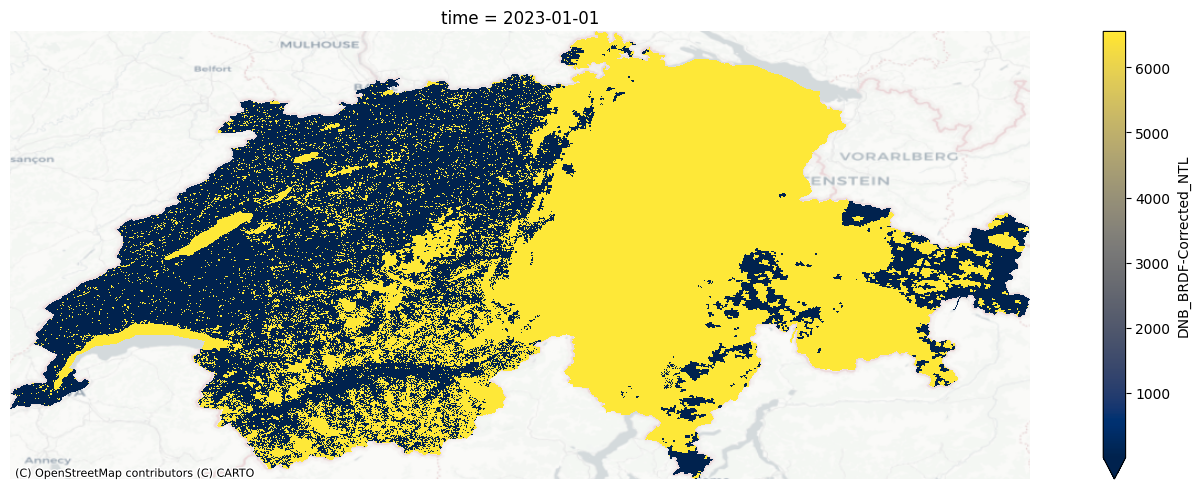

In [10]:
fig, ax = plt.subplots()

ntl_r["DNB_BRDF-Corrected_NTL"].sel(time="2023-01-01").plot(
    robust=True, cmap="cividis"
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout()

We notice that a number of observations are missing, that are poor quality and are not gap-filled. To understand the extent of missing date, we can use the following code to determine (1) the total number of pixels that cover Switzerland, (2) the total number of non-`NA` nighttime light pixels, and (3) the proportion of non-`NA` pixels.

In [16]:
ntl_np = ntl_r["DNB_BRDF-Corrected_NTL"].sel(time="2023-01-01")

n_pixel = zonal_stats(
    gdf,
    ntl_np.values,
    affine=transform(ntl_np),
    nodata=np.nan,
    masked=False,
    stats=["count", "nan"],
)

In [17]:
## Number of pixels
n_pixel[0]["count"] + n_pixel[0]["nan"]

280801.0

In [18]:
## Number of non nan pixels
n_pixel[0]["count"]

279680

In [19]:
## Proportion of non nan pixels
n_pixel[0]["count"] / (n_pixel[0]["count"] + n_pixel[0]["nan"])

0.9960078489748968

By default, `bm_extract` computes the mean; we can easily also compute the number of pixels and number of nan pixels.

In [20]:
date_range = pd.date_range(
    "2023-01-01",
    "2023-01-10",
    freq="D",
)

ntl_df = bm_extract(
    roi=gdf,
    product_id="VNP46A2",
    date_range=date_range,
    bearer=bearer,
    variable="DNB_BRDF-Corrected_NTL",
    aggfunc=["mean", "count", "nan"],
)

GETTING MANIFEST...:   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading...:   0%|          | 0/20 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0.00/6.15M [00:00<?, ?B/s]

  0%|          | 0.00/5.96M [00:00<?, ?B/s]

  0%|          | 0.00/6.79M [00:00<?, ?B/s]

  0%|          | 0.00/3.96M [00:00<?, ?B/s]

  0%|          | 0.00/4.66M [00:00<?, ?B/s]

  0%|          | 0.00/5.47M [00:00<?, ?B/s]

  0%|          | 0.00/4.34M [00:00<?, ?B/s]

  0%|          | 0.00/6.75M [00:00<?, ?B/s]

  0%|          | 0.00/4.39M [00:00<?, ?B/s]

  0%|          | 0.00/6.18M [00:00<?, ?B/s]

  0%|          | 0.00/6.78M [00:00<?, ?B/s]

  0%|          | 0.00/5.01M [00:00<?, ?B/s]

  0%|          | 0.00/5.00M [00:00<?, ?B/s]

  0%|          | 0.00/5.44M [00:00<?, ?B/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

[2023-12-20 17:50:42 - backoff:105 - INFO] Backing off _download_file(...) for 0.0s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:50:43 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:50:43 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:50:43 - backoff:105 - INFO] Backing off _download_file(...) for 0.9s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:50:43 - backoff:105 - INFO] Backing off _download_file(...) for 0.2s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:50:45 - backoff:105 - INFO] Backing off _download_file(...) for 0.4s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:50:45 - backoff:105 - INFO] Backing off _download_file(...) for 0.9s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:50:45 - backoff:105 - INFO] Backing off _downlo

  0%|          | 0.00/5.01M [00:00<?, ?B/s]

  0%|          | 0.00/4.39M [00:00<?, ?B/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/5.44M [00:00<?, ?B/s]

  0%|          | 0.00/5.47M [00:00<?, ?B/s]

  0%|          | 0.00/6.15M [00:00<?, ?B/s]

  0%|          | 0.00/6.79M [00:00<?, ?B/s]

  0%|          | 0.00/4.34M [00:00<?, ?B/s]

  0%|          | 0.00/5.00M [00:00<?, ?B/s]

  0%|          | 0.00/5.96M [00:00<?, ?B/s]

  0%|          | 0.00/6.18M [00:00<?, ?B/s]

  0%|          | 0.00/6.75M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

  0%|          | 0.00/6.78M [00:00<?, ?B/s]

  0%|          | 0.00/4.66M [00:00<?, ?B/s]

  0%|          | 0.00/3.96M [00:00<?, ?B/s]

[2023-12-20 17:51:14 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:51:14 - backoff:105 - INFO] Backing off _download_file(...) for 0.8s (httpx.ConnectTimeout: _ssl.c:989: The handshake operation timed out)
[2023-12-20 17:51:14 - backoff:105 - INFO] Backing off _download_file(...) for 0.1s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:51:14 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:51:14 - backoff:105 - INFO] Backing off _download_file(...) for 1.0s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:51:15 - backoff:105 - INFO] Backing off _download_file(...) for 1.8s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:51:15 - backoff:105 - INFO] Backing off _download_file(...) for 1.3s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:51:16 - backoff:105 - INFO]

  0%|          | 0.00/6.18M [00:00<?, ?B/s]

  0%|          | 0.00/5.65M [00:00<?, ?B/s]

  0%|          | 0.00/4.34M [00:00<?, ?B/s]

  0%|          | 0.00/6.79M [00:00<?, ?B/s]

  0%|          | 0.00/4.66M [00:00<?, ?B/s]

  0%|          | 0.00/5.96M [00:00<?, ?B/s]

  0%|          | 0.00/6.15M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

  0%|          | 0.00/6.78M [00:00<?, ?B/s]

  0%|          | 0.00/6.75M [00:00<?, ?B/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/3.96M [00:00<?, ?B/s]

  0%|          | 0.00/4.24M [00:00<?, ?B/s]

  0%|          | 0.00/5.47M [00:00<?, ?B/s]

[2023-12-20 17:51:29 - backoff:105 - INFO] Backing off _download_file(...) for 2.3s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:51:29 - backoff:105 - INFO] Backing off _download_file(...) for 0.6s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:51:37 - backoff:105 - INFO] Backing off _download_file(...) for 1.1s (httpx.ConnectTimeout: _ssl.c:989: The handshake operation timed out)
[2023-12-20 17:51:38 - backoff:105 - INFO] Backing off _download_file(...) for 0.7s (httpx.ConnectTimeout: _ssl.c:989: The handshake operation timed out)
[2023-12-20 17:51:47 - backoff:105 - INFO] Backing off _download_file(...) for 2.7s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:51:47 - backoff:105 - INFO] Backing off _download_file(...) for 2.0s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:51:48 - backoff:105 - INFO] Backing off _download_file(...) for 0.5s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:51:48 -

  0%|          | 0.00/5.00M [00:00<?, ?B/s]

  0%|          | 0.00/5.47M [00:00<?, ?B/s]

  0%|          | 0.00/6.15M [00:00<?, ?B/s]

  0%|          | 0.00/4.24M [00:00<?, ?B/s]

  0%|          | 0.00/6.79M [00:00<?, ?B/s]

  0%|          | 0.00/3.96M [00:00<?, ?B/s]

  0%|          | 0.00/6.18M [00:00<?, ?B/s]

  0%|          | 0.00/4.66M [00:00<?, ?B/s]

  0%|          | 0.00/5.91M [00:00<?, ?B/s]

  0%|          | 0.00/4.34M [00:00<?, ?B/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

[2023-12-20 17:52:02 - backoff:105 - INFO] Backing off _download_file(...) for 6.0s (httpx.ConnectTimeout: _ssl.c:989: The handshake operation timed out)
[2023-12-20 17:52:02 - backoff:105 - INFO] Backing off _download_file(...) for 5.6s (httpx.ConnectTimeout: _ssl.c:989: The handshake operation timed out)
[2023-12-20 17:52:02 - backoff:105 - INFO] Backing off _download_file(...) for 4.4s (httpx.ConnectTimeout: _ssl.c:989: The handshake operation timed out)
[2023-12-20 17:52:02 - backoff:105 - INFO] Backing off _download_file(...) for 0.3s (httpx.ConnectTimeout: _ssl.c:989: The handshake operation timed out)
[2023-12-20 17:52:14 - backoff:105 - INFO] Backing off _download_file(...) for 3.9s (httpx.ConnectTimeout: _ssl.c:989: The handshake operation timed out)
[2023-12-20 17:52:14 - backoff:105 - INFO] Backing off _download_file(...) for 5.5s (httpx.ReadTimeout: The read operation timed out)
[2023-12-20 17:52:16 - backoff:105 - INFO] Backing off _download_file(...) for 6.0s (httpx.Conne

  0%|          | 0.00/6.79M [00:00<?, ?B/s]

  0%|          | 0.00/5.65M [00:00<?, ?B/s]

  0%|          | 0.00/6.32M [00:00<?, ?B/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

  0%|          | 0.00/5.96M [00:00<?, ?B/s]

  0%|          | 0.00/6.78M [00:00<?, ?B/s]

  0%|          | 0.00/6.75M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/20 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
ntl_df["prop_non_na_pixels"] = ntl_df["ntl_count"] / (
    ntl_df["ntl_count"] + ntl_df["ntl_nan"]
)

In [22]:
ntl_df

COUNTRY ID_0                                           geometry  \
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   
0  Switzerland  CHE  MULTIPOLYGON (((7.04510 45.95732, 7.04454 45.9...   

      ntl_mean  ntl_count  ntl_nan       date  prop_non_na_pixels  
0  3727.869732     279680   1121.0 2023-01-01            0.996008  
0  3432.243747     279680   1121.0 2023-01-02            0.996008  
0  6324.832621     279680   1121.0 2023-01-03            0.996008  
0  3611.830791     279680   1121.0 2023-01-04            0.996008  
0  6383.862675     279680   1121.0 2023-01-05            0.996008  
0  3632.086362     279680   1121.0 2023-01-06            0.996008  
0  4481.098618     279680   1121.0 2023-01-07            0.996008  
0  3740.919484     279680   1121.0 2023-01-08            0.996008  
0  5955.132521     279680   1121.0 2023-01-09            0.996008  
0  5595.069880     279680   1121.0 2023-01-10            0.996008

The below figure shows trends in average nighttime lights (left) and the proportion of the country with a value for nighttime lights (right). For some days, low number of pixels corresponds to low nighttime lights (eg, January 3 and 5th); however, for other days, low number of pixels corresponds to higher nighttime lights (eg, January 9 and 10). On January 3 and 5, missing pixels could have been over typically high-lit areas (eg, cities)---while on January 9 and 10, missing pixels could have been over typically lower-lit areas. 


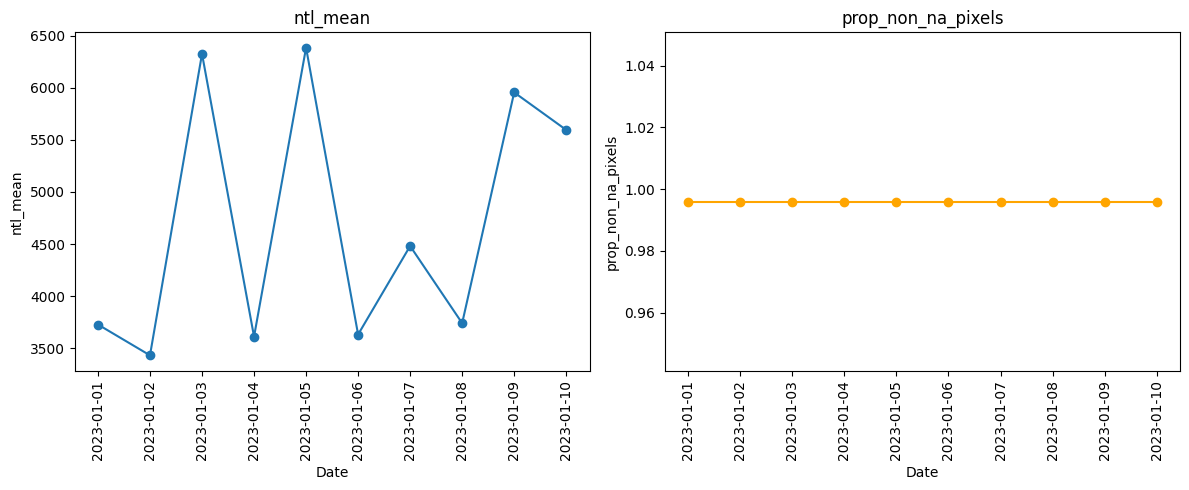

In [23]:
fig, axs = plt.subplots(
    1, 2, figsize=(12, 5)
)  # 1 row, 2 columns for side-by-side plots

# Left plot (date vs ntl_mean)
axs[0].plot(ntl_df["date"], ntl_df["ntl_mean"], marker="o", linestyle="-")
axs[0].set_title("ntl_mean")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("ntl_mean")
axs[0].tick_params(axis="x", rotation=90)

# Right plot (date vs prop_na)
axs[1].plot(
    ntl_df["date"],
    ntl_df["prop_non_na_pixels"],
    marker="o",
    linestyle="-",
    color="orange",
)
axs[1].set_title("prop_non_na_pixels")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("prop_non_na_pixels")
axs[1].tick_params(axis="x", rotation=90)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plots
plt.show()

#### Quality <a name="daily-quality"></a>

For daily data, the quality values are:

* 0: High-quality, Persistent nighttime lights

* 1: High-quality, Ephemeral nighttime Lights

* 2: Poor-quality, Outlier, potential cloud contamination, or other issues

* 255: No retrieval, Fill value (masked out on ingestion)

We can map quality by using the `Mandatory_Quality_Flag` variable.

In [24]:
quality_r = bm_raster(
    gdf,
    product_id="VNP46A2",
    date_range="2023-01-01",
    bearer=bearer,
    variable="Mandatory_Quality_Flag",
)

GETTING MANIFEST...:   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/robmarty/opt/anaconda3/envs/jupyterlab/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:201: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


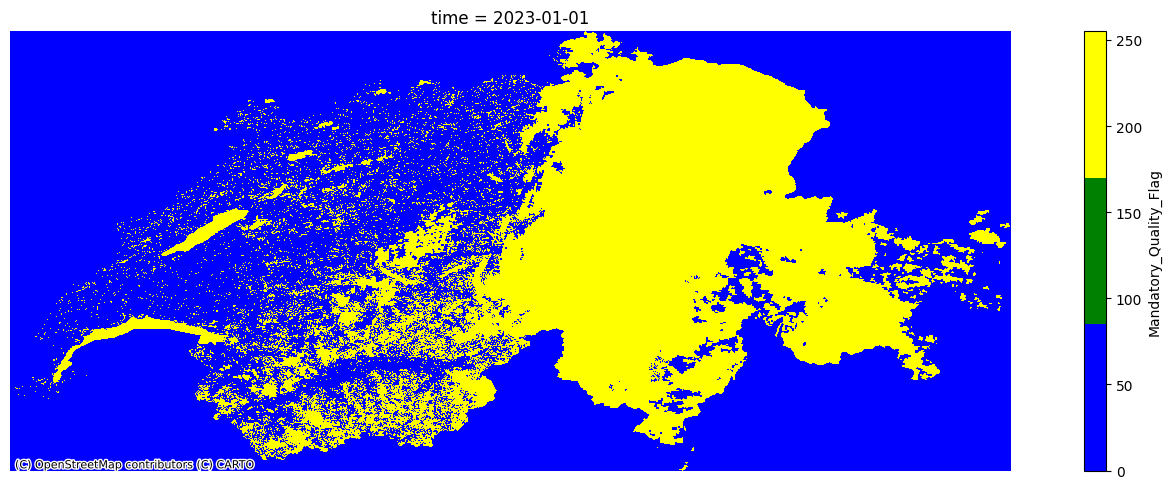

In [27]:
fig, ax = plt.subplots()

# Create a discrete colormap
cmap = mcolors.ListedColormap(["blue", "green", "yellow"])
# Plot
quality_r["Mandatory_Quality_Flag"].sel(time="2023-01-01").plot(ax=ax, cmap=cmap)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout();

#### Nighttime lights for good quality observations <a name="daily-goodq"></a>

The `quality_flag_rm` parameter determines which pixels are set to `NA` based on the quality indicator. By default, only pixels with a value of `255` are filtered out. However, if we only want data for good quality pixels, we can adjust the `quality_flag_rm` parameter.

In [29]:
ntl_good_qual_r = bm_raster(
    gdf,
    product_id="VNP46A2",
    date_range="2023-01-01",
    bearer=bearer,
    variable="DNB_BRDF-Corrected_NTL",
    quality_flag_rm=[2],
)

GETTING MANIFEST...:   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/5.22M [00:00<?, ?B/s]

  0%|          | 0.00/5.09M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

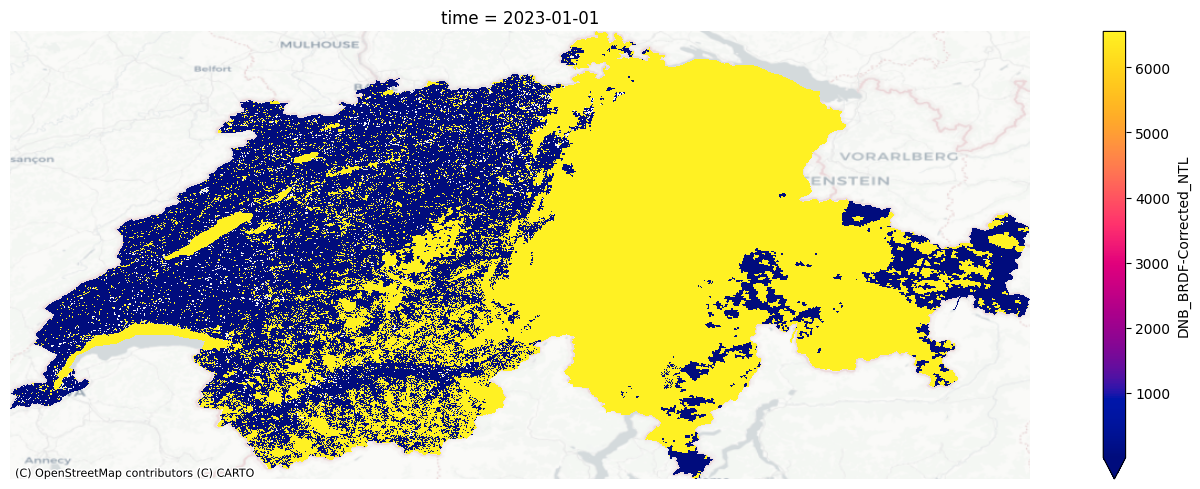

In [31]:
fig, ax = plt.subplots()

# Plot
ntl_good_qual_r["DNB_BRDF-Corrected_NTL"].sel(time="2023-01-01").plot(
    ax=ax, cmap=cc.cm.bmy, robust=True
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout()

Instead of using `Gap_Filled_DNB_BRDF-Corrected_NTL`, we could ignore gap filled observations---using the `DNB_BRDF-Corrected_NTL` variable. Here, we also remove poor quality pixels.

### Monthly/Annual Data <a name="ma"></a>

Below shows an example examining quality for monthly data (`VNP46A3`). The same approach can be used for annual data (`VNP46A4`); the variables are the same for both monthly and annual data.

#### Nighttime Lights <a name="ma-ntl"></a>

We download data for January 2023. When the `variable` parameter is not specified, `bm_raster` creates a raster using the `NearNadir_Composite_Snow_Free` variable for monthly and annual data---which is nighttime lights, removing effects from snow cover. 

In [11]:
ntl_r = bm_raster(
    gdf,
    product_id="VNP46A3",
    date_range="2023-01-01",
    bearer=bearer,
    variable="NearNadir_Composite_Snow_Free",
)

GETTING MANIFEST...:   0%|          | 0/2 [00:00<?, ?it/s]

[2023-12-20 18:05:25 - backoff:105 - INFO] Backing off get_url(...) for 1.0s (httpx.ConnectTimeout)


QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/25.2M [00:00<?, ?B/s]

  0%|          | 0.00/28.6M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

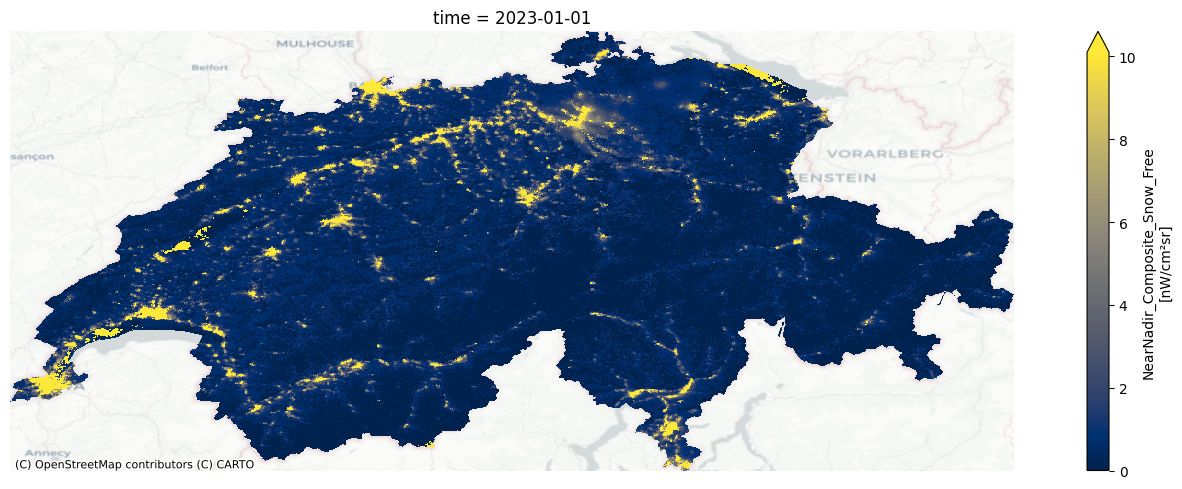

In [12]:
fig, ax = plt.subplots()

ntl_r["NearNadir_Composite_Snow_Free"].sel(time="2023-01-01").plot(
    robust=True, cmap="cividis"
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout()

#### Number of Observations <a name="ma-numobs"></a>

Black Marble removes poor quality observations, such as pixels covered by clouds. To determine the number of observations used to generate nighttime light values for each pixel, we add `_Num` to the variable name.

In [ ]:
cf_r = bm_raster(
    gdf,
    product_id="VNP46A3",
    date_range="2023-01-01",
    bearer=bearer,
    variable="NearNadir_Composite_Snow_Free_Num",
)

GETTING MANIFEST...:   0%|          | 0/2 [00:00<?, ?it/s]

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/28.6M [00:00<?, ?B/s]

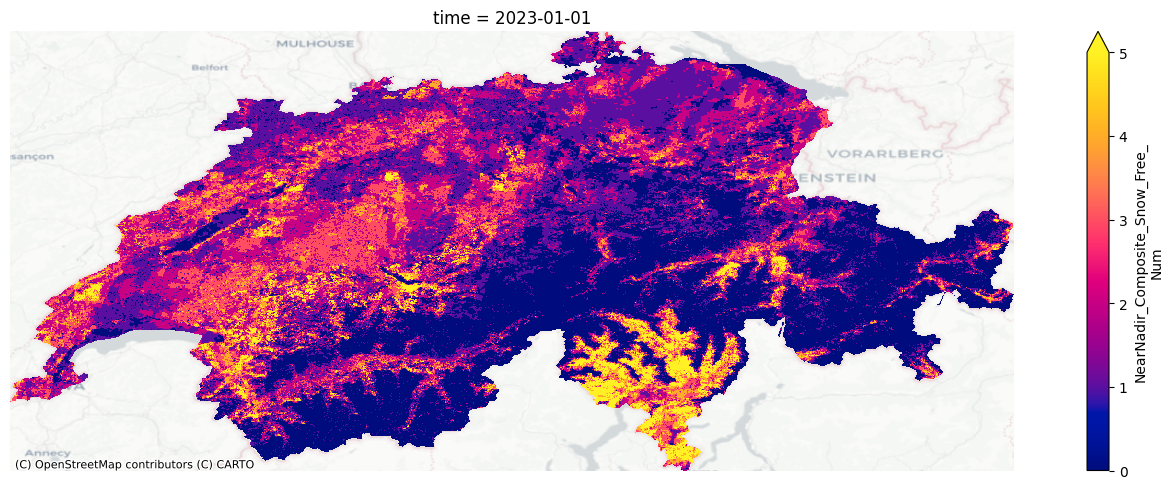

In [25]:
fig, ax = plt.subplots()

cf_r["NearNadir_Composite_Snow_Free_Num"].sel(time="2023-01-01").plot(
    robust=True, cmap=cc.cm.bmy
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout()

#### Quality <a name="ma-quality"></a>

For monthly and annual data, the quality values are:

* 0: Good-quality, The number of observations used for the composite is larger than 3

* 1: Poor-quality, The number of observations used for the composite is less than or equal to 3

* 2: Gap filled NTL based on historical data

* 255: Fill value

We can map quality by adding `_Quality` to the variable name.


In [26]:
quality_r = bm_raster(
    gdf,
    product_id="VNP46A3",
    date_range="2023-01-01",
    bearer=bearer,
    variable="NearNadir_Composite_Snow_Free_Quality",
)

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/28.6M [00:00<?, ?B/s]

  0%|          | 0.00/25.2M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

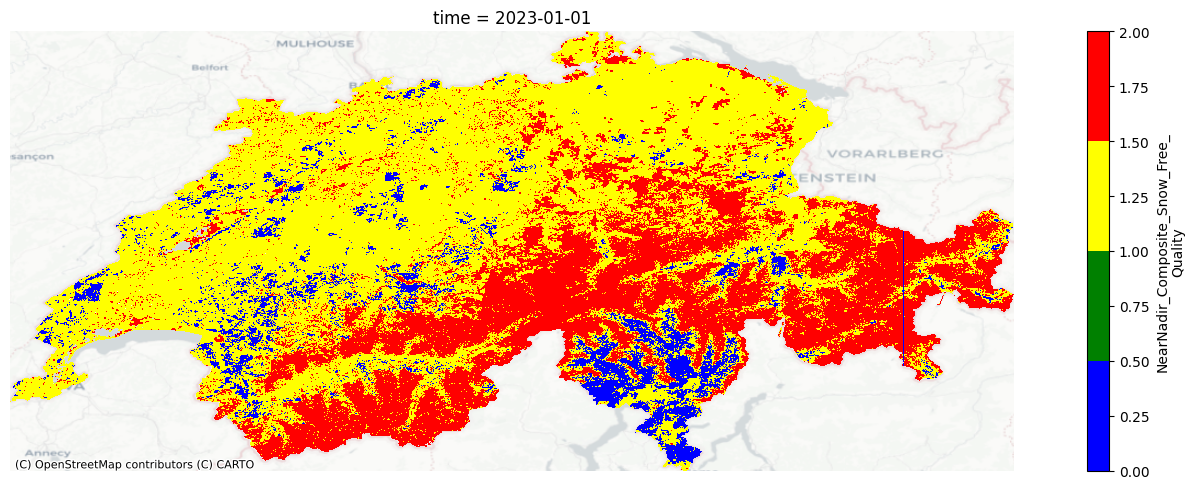

In [27]:
fig, ax = plt.subplots()

# Create a discrete colormap
cmap = mcolors.ListedColormap(["blue", "green", "yellow", "red"])
# Plot
quality_r["NearNadir_Composite_Snow_Free_Quality"].sel(time="2023-01-01").plot(
    ax=ax, cmap=cmap
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout();

#### Nighttime lights for good quality observations <a name="ma-ntl_gq"></a>

The `quality_flag_rm` parameter determines which pixels are set to `NA` based on the quality indicator. By default, only pixels with a value of `255` are filtered out. However, if we also want to remove poor quality pixels, we can adjust the `quality_flag_rm` parameter.

In [28]:
ntl_good_qual_r = bm_raster(
    gdf,
    product_id="VNP46A3",
    date_range="2023-01-01",
    bearer=bearer,
    variable="NearNadir_Composite_Snow_Free",
    quality_flag_rm=[1, 255],
)

QUEUEING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0.00/25.2M [00:00<?, ?B/s]

  0%|          | 0.00/28.6M [00:00<?, ?B/s]

COLLECTING RESULTS | Downloading...:   0%|          | 0/2 [00:00<?, ?it/s]

COLLATING RESULTS | Processing...:   0%|          | 0/1 [00:00<?, ?it/s]

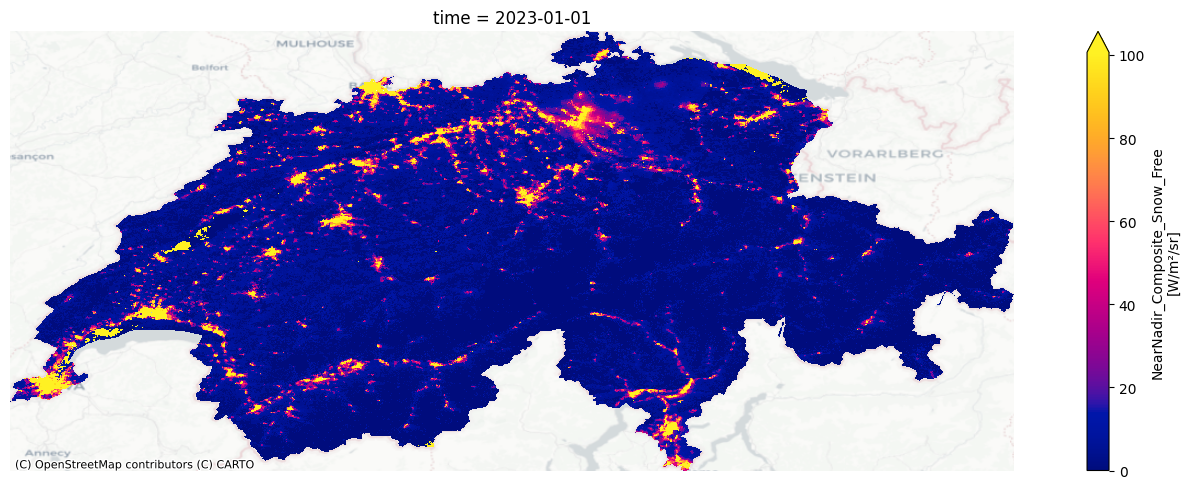

In [29]:
fig, ax = plt.subplots()

# Plot
ntl_r["NearNadir_Composite_Snow_Free"].sel(time="2023-01-01").plot(
    ax=ax, cmap=cc.cm.bmy, robust=True
)
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

plt.axis("off")
plt.tight_layout()